# Galerkin block assembly efficiency and precision demo

In [1]:
from kl_decomposition import galerkin
import numpy as np
import pandas as pd
import time

# ----------------------------------------
# Benchmark configuration
# ----------------------------------------

f_vals = [1e1, 1e4, 1e7, 1e10]  # sweep these values
comp_degree = 30                 # polynomial degree of basis

time_budget = 10.0                # seconds per micro‑benchmark (averaging window)
time_cap = 0.5                    # *average* build time threshold – if exceeded, stop increasing quad

# Quadrature sizes to test (ascending so "break" works)
quad_points_duffy = list(range(10, 100, 1)) + list(range(100, 500, 10))
quad_points_gauss = list(range(10, 100, 1)) + list(range(100, 500, 10)) + list(range(500, 4000, 50))

g_values = [1, 2, 3, 4, 5]    # g‑parameters for Duffy mapping

# ----------------------------------------
# Main benchmark loops
# ----------------------------------------

results = []  # collected as (f, gx, gy, quad, err, duration)

for f_val in f_vals:
    # Build a high‑fidelity reference matrix (fixed mapping & dense quadrature)
    A_ref = galerkin.assemble_duffy(
        f=f_val, degree=comp_degree, quad=1000, gx=4.0, gy=4.0
    )
    A_ref_norm = np.linalg.norm(A_ref)

    # =====================================================
    # Duffy assembly tests – skip larger quad once too slow
    # =====================================================
    for gx in g_values:
        for quad in quad_points_duffy:
            # --------------------
            # Micro‑benchmark block
            # --------------------
            t0 = time.perf_counter()
            it = 0
            while time.perf_counter() - t0 < time_budget:
                A_duf = galerkin.assemble_duffy(
                    f=f_val, degree=comp_degree, quad=quad, gx=gx, gy=gx
                )
                it += 1
                if it >=100:
                    break
            duration = (time.perf_counter() - t0) / it  # average per build
            err = np.linalg.norm(A_duf - A_ref)
            results.append((f_val, gx, gx, quad, err, duration))
            print(
                f"[f={f_val:.1e}] Duffy gx={gx:.1f}, quad={quad} "
                f"-> err={err:.2e}, time={duration:.3f}s"
            )

            # If this quad is slower than the threshold, no point in testing larger quads
            if duration > time_cap:
                print(
                    f"      ↳ duration {duration:.2f}s > {time_cap}s – skipping larger quads for gx={gx}"
                )
                break  # exit quad loop, continue with next gx
            if err / A_ref_norm < 1e-12:
                print(
                    f"      ↳ error {err:.2e} / {A_ref_norm:.2e} > 1e-12 – skipping larger quads for gx={gx}"
                )
                break

    # =====================================================
    # Gauss‑Legendre 2‑D tests – same early exit logic
    # =====================================================
    for quad in quad_points_gauss:
        t0 = time.perf_counter()
        it = 0
        while time.perf_counter() - t0 < time_budget:
            A_gauss = galerkin.assemble_gauss2d(
                f=f_val, degree=comp_degree, quad=quad
            )
            it += 1
            if it >= 100:
                break
        duration = (time.perf_counter() - t0) / it
        err = np.linalg.norm(A_gauss - A_ref)
        results.append((f_val, np.nan, np.nan, quad, err, duration))
        print(
            f"[f={f_val:.1e}] Gauss2D quad={quad} "
            f"-> err={err:.2e}, time={duration:.3f}s"
        )
        if duration > time_cap:
            print(
                f"      ↳ duration {duration:.2f}s > {time_cap}s – skipping larger Gauss quad values"
            )
            break
        if err / A_ref_norm < 1e-12:
            print(
                f"      ↳ error {err:.2e} / {A_ref_norm:.2e} > 1e-12 – skipping larger quads for gx={gx}"
            )
            break

# ----------------------------------------
# Persist results for later analysis
# ----------------------------------------

df = pd.DataFrame(
    results,
    columns=["f", "gx", "gy", "quad", "frobenius_error", "time_sec"],
)

df.to_csv("data/duffy_precision_test.csv", index=False)
print("Results saved to duffy_precision_test.csv")

[f=1.0e+01] Duffy gx=1.0, quad=10 -> err=9.80e-01, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=11 -> err=9.23e-01, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=12 -> err=8.81e-01, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=13 -> err=8.53e-01, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=14 -> err=7.03e-01, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=15 -> err=3.81e-01, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=16 -> err=1.19e-01, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=17 -> err=2.52e-02, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=18 -> err=4.20e-03, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=19 -> err=5.51e-04, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=20 -> err=5.98e-05, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=21 -> err=5.60e-06, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=22 -> err=4.60e-07, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=23 -> err=3.33e-08, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=24 -> err=2.16e-09, time=0.001s
[f=1.0e+01] Duffy gx=1.0, quad=25 -> err=1.26e-10, time

# Plots the results from exported CSV

Saved figure to duffy_precision_plots_time.pdf


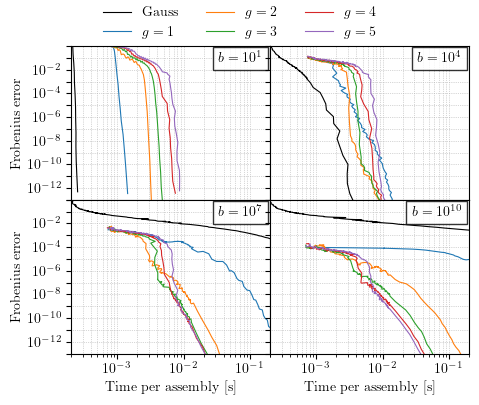

In [9]:
"""
duffy_precision_plots_time.py
=============================
Compact 2×2 log-log plots with fixed limits:

    x-range: 1 e-4 … 5 e-1
    y-range: 1 e-13 … 1

Layout rules
------------
• Only the left column shows y-axis ticks and label.
• Only the bottom row shows x-axis ticks and label.
• No titles; a tiny 'f = 10^k' text sits in the upper-right
  corner of each subplot.
• Panels are packed as tightly as possible.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Matplotlib / LaTeX styling
# ---------------------------------------------------------------------
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.size": 10,
        "axes.labelsize": 10,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
)

# ---------------------------------------------------------------------
# Load data
# ---------------------------------------------------------------------
df = pd.read_csv("data/duffy_precision_test.csv")

f_vals = sorted(df["f"].unique())          # 10¹, 10⁴, 10⁷, 10¹⁰
g_values = [1, 2, 3, 4, 5]
colors_g = plt.rcParams["axes.prop_cycle"].by_key()["color"][: len(g_values)]

# ---------------------------------------------------------------------
# Figure: 2 × 2 shared-axis grid
# ---------------------------------------------------------------------
fig, axes = plt.subplots(
    2, 2,
    figsize=(4.35, 3.75),          # slightly smaller to trim margins
    sharex=True,
    sharey=True
)

# *Almost* zero spacing between panels
fig.subplots_adjust(
    wspace=0.00, hspace=0.00,    # internal gaps
    left=0.08, right=0.995,      # figure borders
    bottom=0.08, top=0.90
)

handles_master, labels_master = [], []

for idx, (ax, f_val) in enumerate(zip(axes.flat, f_vals)):
    sub = df[df["f"] == f_val]

    # --- Gauss (gx NaN) -------------------------------------------------
    gauss = sub[sub["gx"].isna()]
    if not gauss.empty:
        (h_gauss,) = ax.plot(
            gauss["time_sec"], gauss["frobenius_error"],
            "-", lw=0.8, color="black", label="Gauss"
        )
        if not handles_master:
            handles_master.append(h_gauss)
            labels_master.append("Gauss")

    # --- Duffy, coloured by g ------------------------------------------
    for g, color in zip(g_values, colors_g):
        dat = sub[sub["gx"] == g]
        if dat.empty:
            continue
        (h,) = ax.plot(
            dat["time_sec"], dat["frobenius_error"],
            "-", lw=0.8, color=color, label=fr"$g={g}$"
        )
        if idx == 0:                      # collect legend handles once
            handles_master.append(h)
            labels_master.append(fr"$g={g}$")

    # --- Common log-log limits -----------------------------------------
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(2e-4, 0.2)
    ax.set_ylim(1e-13, 1)
    ax.grid(True, which="both", ls=":", lw=0.5)

    # --- Axis labels / tick labels -------------------------------------
    col = idx % 2
    row = idx // 2
    yticks = 10.0 ** np.arange(-13, 1)
    yticklabels = [
        fr"$10^{{{exp}}}$" if (exp % 2 == 0 and exp < 0) else "" for exp in range(-13, 1)
    ]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    if col == 0:                          # left column
        ax.set_ylabel("Frobenius error")
        # Custom y-ticks and tick labels
    else:
        ax.tick_params(labelleft=False)   # hide y tick labels

    if row == 1:                          # bottom row
        ax.set_xlabel("Time per assembly [s]")
    else:
        ax.tick_params(labelbottom=False)  # hide x tick labels

    # --- Corner text ----------------------------------------------------
    exponent = int(np.log10(f_val))
    # Add white box behind the text for better visibility
    ax.text(
        0.96, 0.96,                     # even tighter to the corner
        fr"$b = 10^{{{exponent}}}$",
        transform=ax.transAxes,
        ha="right", va="top",
        bbox=dict(facecolor="white", edgecolor="k", pad=3.9, alpha=0.8)
    )

# ---------------------------------------------------------------------
# Legend across top
# ---------------------------------------------------------------------
fig.legend(
    handles_master,
    labels_master,
    loc="upper center",
    ncol=3,
    frameon=False,
    borderaxespad=0.1,
)

fig.savefig("duffy_precision_plots_time.pdf", bbox_inches="tight")
print("Saved figure to duffy_precision_plots_time.pdf")
plt.show()